Train discriminative model (LSTM) to evaluate the label quality produced by EMERGE. The following shows training LSTM on one dataset.

In [1]:
import sys, os, glob
import pandas as pd
import numpy as np
import random

from sklearn import *

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sys.path.append('../')
from utils import get_full_path

In [2]:
db_dir = get_full_path('data_28')

snuba_split_set_dir = get_full_path('snuba', 'input_snuba')
output_dir = get_full_path('snuba', 'results')

from snuba.data.data_loader import DataLoader
from snuba.program_synthesis.heuristic_generator import HeuristicGenerator
from snuba.program_synthesis.synthesizer import Synthesizer
from snuba.program_synthesis.verifier import Verifier
from snuba.lstm.lstm import *

Using TensorFlow backend.


In [3]:
np.random.seed(42)

In [4]:
os.chdir(db_dir)
datasets = glob.glob('*.csv')
datasets_sorted = sorted(datasets)
print(datasets_sorted)

['dataset_00.csv', 'dataset_01.csv', 'dataset_02.csv', 'dataset_03.csv', 'dataset_04.csv', 'dataset_05.csv', 'dataset_06.csv', 'dataset_07.csv', 'dataset_08.csv', 'dataset_09.csv', 'dataset_10.csv', 'dataset_11.csv', 'dataset_12.csv', 'dataset_13.csv', 'dataset_14.csv', 'dataset_15.csv', 'dataset_16.csv', 'dataset_17.csv', 'dataset_18.csv', 'dataset_19.csv', 'dataset_20.csv', 'dataset_21.csv', 'dataset_22.csv', 'dataset_23.csv', 'dataset_24.csv', 'dataset_25.csv', 'dataset_26.csv', 'dataset_27.csv']


In [5]:
# Choose dataset_00
client1 = datasets_sorted[0]
client1

'dataset_00.csv'

In [6]:
def load_data(client):
    input_dir = snuba_split_set_dir+'/'+str(client[:-4])
    os.chdir(input_dir)
    train_original = pd.read_csv(glob.glob('train_original_*')[0])
    val_original = pd.read_csv(glob.glob('val_original_*')[0])
    test_original = pd.read_csv(glob.glob('test_original_*')[0])
    
    train_probs = np.load(glob.glob('probs_labels*')[0])
    val_ground = np.load(glob.glob('val_ground_*')[0])
    test_ground = np.load(glob.glob('test_ground_*')[0])
    
    return train_original, val_original, test_original, train_probs, val_ground, test_ground
    

In [7]:
train_original, val_original, test_original, train_probs, val_ground, test_ground = load_data(client1)

In [8]:
train_data = train_original['rtt']
val_data = val_original['rtt']
test_data = test_original['rtt']

In [9]:
def validate(client):
    client = client[:-4]
    heuristic = 'emerge'
    
    bs = 128
    n = 20
    num_cells = 128
    lr = 0.005
    l2_reg = 0.05
    dropout_val = 0.0

    y_pred = lstm_simple(train_data, train_probs, val_data, val_ground, client, heuristic,\
                                bs=bs, n=n, num_cells=num_cells, lr=lr, l2_reg=l2_reg, dropout_val=dropout_val)

    predictions = np.round(y_pred)

    val_acc = np.sum(predictions == val_ground)/float(np.shape(val_ground)[0])
    val_f1 = metrics.f1_score(val_ground, predictions, average='micro', zero_division=0)
    val_pr = metrics.precision_score(val_ground, predictions, average='micro', zero_division=0)
    val_re = metrics.recall_score(val_ground, predictions, average='micro', zero_division=0)


    print ('=================================================================')
    print ('      EMERGE Validation Results')
    
    print ('=================================================================')

    print ('Validation Accuracy: ', val_acc)
    print ('Validation F1 Score: ', val_f1)
    print ('Validation Best Pr: ', val_pr)
    print ('Validation Best Re: ', val_re)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3334 samples, validate on 834 samples
Epoch 1/20
3334/3334 [==============================] - 2s 624us/step - loss: 5.7677 - accuracy: 0.0000e+00 - val_loss: 4.8347 - val_accuracy: 0.9916
Epoch 2/20
3334/3334 [==============================] - 2s 538us/step - loss: 4.2272 - accuracy: 0.0000e+00 - val_loss: 3.5254 - val_accuracy: 0.9928
Epoch 3/20
3334/3334 [==============================] - 2s 604us/step - loss: 3.0312 - accuracy: 0.0000e+00 - val_loss: 2.5078 - val_accuracy: 0.9928
Epoch 4/20
3334/3334 [==============================] - 2s 612us/step - loss: 2.1352 - accuracy: 0.0000e+00 - val_loss: 1.7627 - val_accuracy: 0.9916
Epoch 5/20
3334/3334 [==============================] - 2s 607us/step - loss: 1.5237 - accuracy: 0.0000e+00 - val_loss: 1.2276 - val_accuracy: 0.9844
Epoch 6/20
3334/3334 [=====

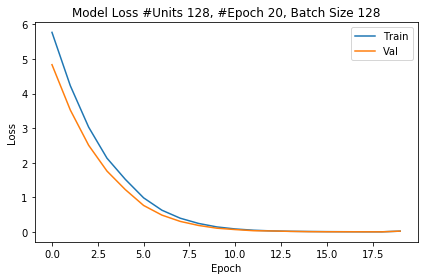

Accuracy: 99.40%
      EMERGE Validation Results
Validation Accuracy:  0.9940047961630696
Validation F1 Score:  0.9940047961630696
Validation Best Pr:  0.9940047961630696
Validation Best Re:  0.9940047961630696


In [10]:
validate(client1)

In [11]:
def test(client):
    client = client[:-4]
    heuristic = 'emerge'
    
    results_dir = output_dir+'/'+str(client1[:-4])
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    os.chdir(results_dir)
    
    # Take RTT data for train, val, and test set
    train_data = train_original['rtt']
    val_data = val_original['rtt']
    test_data = test_original['rtt']

    print ('... Train LSTM ...')

    bs = 128
    n = 20
    num_cells = 128
    lr = 0.005
    l2_reg = 0.05
    dropout_val = 0.0
    early_stopping_epoch = n
    y_pred = lstm_simple(train_data, train_probs, test_data, test_ground, client, heuristic,\
                            bs=bs, n=n, num_cells=num_cells, lr=lr, l2_reg=l2_reg, dropout_val=dropout_val)

    predictions = np.round(y_pred)

    test_acc = np.sum(predictions == test_ground)/float(np.shape(test_ground)[0])
    print ('=================================================================')
    print ('      EMERGE Test Results')
    print ('=================================================================')
    print( 'Test Accuracy: ', test_acc)
    test_f1 = metrics.f1_score(test_ground, predictions, average='micro', zero_division=0)
    print ('Test F1 Score: ', test_f1)
    print ('Test Precision: ', metrics.precision_score(test_ground, predictions, average='micro', zero_division=0))
    print ('Test Recall: ', metrics.recall_score(test_ground, predictions, average='micro', zero_division=0))
    
    
    return test_f1

... Train LSTM ...
Train on 3334 samples, validate on 500 samples
Epoch 1/20
3334/3334 [==============================] - 2s 692us/step - loss: 5.8101 - accuracy: 0.0000e+00 - val_loss: 4.8359 - val_accuracy: 0.9900
Epoch 2/20
3334/3334 [==============================] - 2s 536us/step - loss: 4.2066 - accuracy: 0.0000e+00 - val_loss: 3.5194 - val_accuracy: 0.9960
Epoch 3/20
3334/3334 [==============================] - 2s 636us/step - loss: 3.0596 - accuracy: 0.0000e+00 - val_loss: 2.5042 - val_accuracy: 0.9960
Epoch 4/20
3334/3334 [==============================] - 2s 619us/step - loss: 2.1895 - accuracy: 0.0000e+00 - val_loss: 1.8004 - val_accuracy: 0.9880
Epoch 5/20
3334/3334 [==============================] - 2s 607us/step - loss: 1.4937 - accuracy: 0.0000e+00 - val_loss: 1.1835 - val_accuracy: 0.9940
Epoch 6/20
3334/3334 [==============================] - 2s 659us/step - loss: 1.0029 - accuracy: 0.0000e+00 - val_loss: 0.7799 - val_accuracy: 0.9960
Epoch 7/20
3334/3334 [============

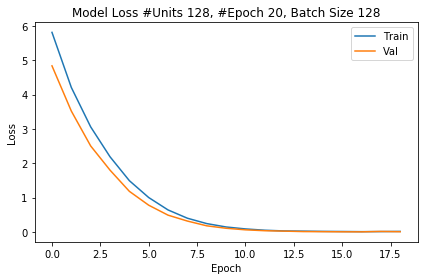

Accuracy: 100.00%
      EMERGE Test Results
Test Accuracy:  1.0
Test F1 Score:  1.0
Test Precision:  1.0
Test Recall:  1.0


1.0

In [12]:
test(client1)